(content:references:sed_part2)=
# Spectral Energy Distribution (SED) Part 2: Fitting SEDs

***Author: Marc Hon***

In this chapter, we will be fitting the Spectral Energy Distribution (SED) of a star based on the synthetic photometry created from model atmospheres of stars as discussed in the previous Section.


## Apparent magnitudes and observed flux


If you are to look up information of a star, for example in [SIMBAD](https://simbad.u-strasbg.fr/simbad/), you will frequently see the following flux information about a source:

```{figure} images/simbad.png
---
height: 350px
width: 850px
name: simbad
---
An example of a star's information on SIMBAD, with flux data highlighted.
```

What's being reported here are not direct flux measurements as we've previously seen, but apparent magnitudes across different bandpasses.

```{important}
Apparent magnitudes are a logarithmic measure of how bright a star or object appears in the sky as seen from Earth. They are much more convenient for reporting the brightness of objects as opposed to quoting flux values that span orders of magnitude! 

By definition, a difference of 1 magnitude corresponds to a brightness ratio of approximately 2.512, meaning an object that is 1 magnitude fainter appears about 2.5 times dimmer.
```

To meaningfully compare observed photometry with synthetic SEDs, it is necessary to convert magnitudes into physical flux units. This depends on whether or not the filter uses the **Vega** or the **AB** magnitude system.

- **Vega**: The magnitudes are calibrated so that the star Vega has magnitude zero in all bands. Therefore, you need to know the zero-point flux, $F_{\lambda, 0}$ ,associated for that specific photometric system. For a given apparent magnitude, the flux is $F_{\lambda} = F_{\lambda, 0} \times 10^{-0.4m}$.

- **AB**: Calibrated in absolute units, so does not use a reference star. Defined such that a source with $F_{\lambda}$ = $3.63\times10^{-20}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$ has an AB magnitude of 0 in every filter, and in general the apparent magnitudes are $m_{\mathrm{AB}}$ = -2.5 $\log F_{\mathrm{\lambda}} - 48.6$.


The functions below encapsulate these conversions, using the `astropy` library to help with the physical constants and units. We will use the `pyphot` library, which provides a very helpful [library of filters](https://mfouesneau.github.io/pyphot/libcontent.html) with information about their wavelengths and zero-point fluxes.

In [108]:
import os
import yaml
import pyphot
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import astropy.constants as const
import pysynphot as S

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.modeling.models import BlackBody
from astropy import coordinates as coords
from scipy.stats import truncnorm, norm
from numpy import log, sqrt, pi
from scipy.special import erf


data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'
os.environ['PYSYN_CDBS'] = str(data_folder_path)

plt.style.use('science')

fs = 18

In [3]:
def mag_to_flux_AB(mag, mag_err):
    """Calculate flux in erg s-1 cm-2 Hz-1."""
    flux = 10 ** (-.4 * (mag + 48.6))
    flux_err = abs(-.4 * flux * np.log(10) * mag_err)
    return flux, flux_err


def get_zero_flux(band):
    """Look for the filter information in the pyphot library of filters."""
    # Load photometry filter library
    filt = pyphot.get_library()[band]
    # Get Vega zero flux in erg / cm2 / s / AA
    f0 = filt.Vega_zero_flux.to('erg/(AA * cm ** 2 * s)').magnitude
    return f0


def get_effective_wavelength(band):
    """Get central wavelength of a specific filter in um."""
    # Load photometry filter library
    filt = pyphot.get_library()[band]
    # Get central wavelength in um
    leff = filt.cl.to('AA').magnitude
    return leff

def convert_f_nu_to_f_lambda(f, l):
    """Convert flux from erf s-1 cm-2 Hz-1 to erg s-1 cm-2 lambda-1."""
    return f * const.c.to(u.AA / u.s).value / l ** 2


def mag_to_flux(mag, mag_err, band):
    """Convert from magnitude to flux.

    mag_to_flux performs the conversion from magnitude to flux in
    erg s-1 cm-2 AA-1.5

    The band parameter is a string representing the filter used and it must
    match exactly the name in pyphots filter database

    If the filter is from PanSTARRS or SDSS, then the magnitude is in the AB
    system. Else it's in the Vega system.
    
    Borrowed from https://github.com/jvines/astroARIADNE
    
    """
    if 'PS1_' in band or 'SDSS_' in band or 'GALEX_' in band:
        # Get flux from AB mag
        flux, flux_err = mag_to_flux_AB(mag, mag_err)
        # Get effective wavelength for bandpass
        leff = get_effective_wavelength(band)
        # Convert from f_nu to f_lambda in erg / cm2 / s / AA
        flux = convert_f_nu_to_f_lambda(flux, leff)
        flux_err = convert_f_nu_to_f_lambda(flux_err, leff)
    else:
        # Get flux in erg / cm2 / s / AA
        f0 = get_zero_flux(band)
        flux = 10 ** (-.4 * mag) * f0
        flux_err = abs(-.4 * flux * np.log(10) * mag_err)
    return flux, flux_err

```{note}
`pyphot` returns fluxes in $F_\nu$ (flux per unit frequency), while we seek $F_\lambda$, the flux per unit wavelength, since we will be plotting SEDs over wavelength. The conversion is

$$
F_\nu =  \frac{c}{\lambda^2}{F_\lambda},
$$

where $c$ is the speed of light. It is for this purpose that the effective wavelength $\lambda$ of each band was required to be determined in the code above.


```

## Retrieving apparent magnitude measurements 

There are a variety of ways to retrieve apparent magnitude measurements for sources. The [SIMBAD](https://simbad.u-strasbg.fr/simbad/) portal often provides flux information from several common bandpasses (e.g., Johnson UBV, *Gaia* G band), but may mass out on measurements from more obscure surveys that are equally useful. Alternatives to comprehensively get a list of photometry are:

- [Virtual Observatory SED Analyzer (VOSA)](http://svo2.cab.inta-csic.es/theory/vosa/): VOSA provides a convenient online interface to first query sky coordinate for a source, and then perform an exhaustive search over databases for available photometry.

- The [`astroquery`](https://astroquery.readthedocs.io/en/latest/index.html) library has tools to programmaticaly query astronomical web forms and databases. For examples on how to do this, see [this link](https://github.com/jvines/astroARIADNE/blob/master/astroARIADNE/librarian.py).


For this exercise, several examples have conveniently been compiled and included alongside this notebook. Let's load an example:



In [56]:
with open(os.path.join(data_folder_path, 'phot_data') +"/ms.yaml", "r") as f:
    data = yaml.safe_load(f)

dist = data["distance_pc"] # Distance in parsec

bands = [entry["band"] for entry in data["photometry"]] # Extract band-wise values
mags = [entry["mag"] for entry in data["photometry"]]
magerrs = [entry["mag_err"] for entry in data["photometry"]]

print('Star ID: ', data["starname"]) # Star name 
for m, me, b in zip(mags, magerrs, bands): # print band name and apparent magnitude and error
    print(m, me,b)

Star ID:  55 Cnc
19.9648113 0.1062631 GALEX_FUV
13.2163258 0.00294659636 GALEX_NUV
4.59 0.05 2MASS_J
4.14 0.05 2MASS_H
4.015 0.036 2MASS_Ks
5.732681 0.02 Gaia_G
6.155681 0.02 Gaia_BP
5.1470094 0.02 Gaia_RP
7.037 0.015 TYCHO_B_MvB
6.036 0.01 TYCHO_V_MvB
4.001 0.318 WISE_RSR_W1
3.296 0.174 WISE_RSR_W2
4.051 0.015 WISE_RSR_W3
4.014 0.03 WISE_RSR_W4


For each band, we will convert magnitudes to flux using `mag_to_flux(mag, mag_err, band)`.

/tmp/ipykernel_729851/3359577824.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral_r')
/tmp/ipykernel_729851/3359577824.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(w_, f_, label=b, c=band_colors[b])


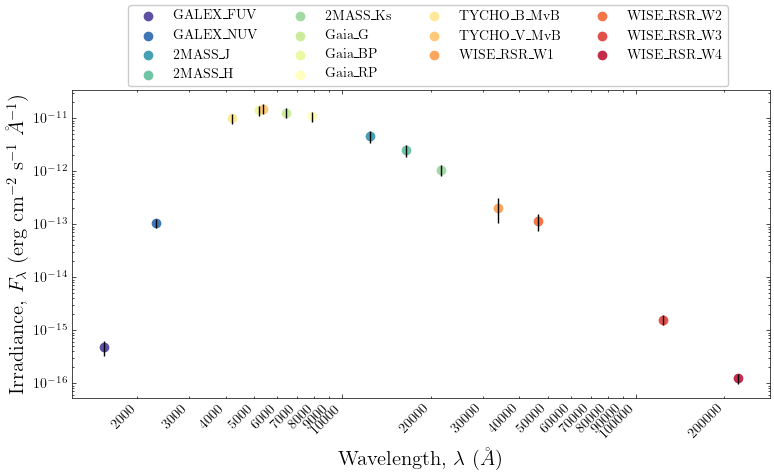

In [57]:
obs_wav, obs_flux, obs_flux_err = [], [], []

n_bands = len(bands)
cmap = cm.get_cmap('Spectral_r')
color_list = [cmap(i / n_bands) for i in range(n_bands)]
band_colors = {band: color for band, color in zip(bands, color_list)}

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

for m, merr,b, in zip(mags, magerrs, bands):
    f_, f_err = mag_to_flux(mag= m, mag_err = merr, band=b)
    f_err += 0.2*f_   # Note: Inflating uncertainty
    w_ = get_effective_wavelength(b)
    ax1.scatter(w_, f_, label=b, c=band_colors[b])
    ax1.errorbar(w_, f_, yerr=f_err, fmt='-', ecolor='k')
    obs_flux.append(f_); obs_flux_err.append(f_err); obs_wav.append(w_)
    
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(framealpha=1, frameon=1, ncol=4, bbox_to_anchor=(0.95, 1.3))
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(minor=True), rotation=45, ha='right'); plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

obs_flux = np.array(obs_flux)[np.argsort(obs_wav)]
obs_flux_err = np.array(obs_flux_err)[np.argsort(obs_wav)]
bands = np.array(bands)[np.argsort(obs_wav)]
obs_wav = np.sort(obs_wav)

```{note}
For brevity, horizontal errorbars corresponding to the effective width of each passband are not shown above. We also assume more realistic errors by infating the flux uncertainties to be 20% of the observed flux value.
```

Now that we have converted observed magnitudes to flux values, we want to compare them with values from models to learn something about the star that we are observing. We will use Markov Chain Monte Carlo (MCMC) to fit synthetic photometry to the observed data and assess how much information that SEDs can provide on stellar parameters.

## Fitting the observed photometry to synthetic photometry

We will use the synthetic photometry from the [Castelli and Kurucz 2004](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/castelli-and-kurucz-atlas) models, another well-known library of stellar atmospheres. 

In [119]:
phot_grid = pd.read_csv(str(data_folder_path) + '/CK09.csv').set_index(['met', 'teff', 'logg'])
phot_grid

2MASS_J       2MASS_H      2MASS_Ks     GALEX_NUV  \
met  teff  logg                                                           
-2.5 3500  0.0   4.996000e+05  4.619353e+05  2.021088e+05  4.232484e+00   
           0.5   5.014510e+05  4.448222e+05  1.909531e+05  7.064660e+00   
           1.0   5.052427e+05  4.229727e+05  1.784930e+05  1.225059e+01   
           1.5   5.055122e+05  3.959714e+05  1.667831e+05  2.385142e+01   
           2.0   5.020867e+05  3.639484e+05  1.575972e+05  5.808576e+01   
...                       ...           ...           ...           ...   
 0.5 48000 4.5   3.918678e+07  1.261939e+07  4.280296e+06  2.158392e+10   
           5.0   3.884345e+07  1.250314e+07  4.238751e+06  2.180255e+10   
     49000 4.5   4.000997e+07  1.287895e+07  4.366115e+06  2.225678e+10   
           5.0   3.965761e+07  1.276020e+07  4.324204e+06  2.248706e+10   
     50000 5.0   4.046279e+07  1.301469e+07  4.408408e+06  2.317231e+10   

                    GALEX_FUV        SDSS_u        SDSS_g        SDSS_r  \
met  teff  logg                                                           
-2.5 3500  0.0   3.635546e-07  3.983628e+03  8.149538e+04  3.169087e+05   
           0.5   4.239363e-07  6.553515e+03  1.142456e+05  3.792471e+05   
           1.0   3.660543e-07  1.102999e+04  1.539556e+05  4.402068e+05   
           1.5   4.840257e-07  1.795447e+04  1.912682e+05  4.883810e+05   
           2.0   1.770867e-06  2.564215e+04  2.147626e+05  5.153433e+05   
...                       ...           ...           ...           ...   
 0.5 48000 4.5   7.088278e+10  4.451326e+09  1.674874e+09  5.794493e+08   
           5.0   7.423922e+10  4.429914e+09  1.672514e+09  5.750950e+08   
     49000 4.5   7.337195e+10  4.572393e+09  1.715348e+09  5.930302e+08   
           5.0   7.694703e+10  4.550026e+09  1.712902e+09  5.883748e+08   
     50000 5.0   7.962793e+10  4.669705e+09  1.753061e+09  6.015906e+08   

                       SDSS_i        SDSS_z        Gaia_G       Gaia_BP  \
met  teff  logg                                                           
-2.5 3500  0.0   4.841759e+05  5.470721e+05  3.550839e+05  1.790237e+05   
           0.5   5.300132e+05  5.725593e+05  3.998374e+05  2.248705e+05   
           1.0   5.736100e+05  5.991485e+05  4.450978e+05  2.738156e+05   
           1.5   6.102816e+05  6.239768e+05  4.834401e+05  3.154342e+05   
           2.0   6.338933e+05  6.414389e+05  5.070017e+05  3.398975e+05   
...                       ...           ...           ...           ...   
 0.5 48000 4.5   2.788151e+08  1.376949e+08  6.792595e+08  1.302458e+09   
           5.0   2.770473e+08  1.361824e+08  6.764076e+08  1.298043e+09   
     49000 4.5   2.850657e+08  1.407661e+08  6.954815e+08  1.334328e+09   
           5.0   2.832170e+08  1.391797e+08  6.924638e+08  1.329647e+09   
     50000 5.0   2.893469e+08  1.421599e+08  7.084432e+08  1.361113e+09   

                      Gaia_RP   TYCHO_B_MvB   TYCHO_V_MvB    WISE_RSR_W1  \
met  teff  logg                                                            
-2.5 3500  0.0   4.930941e+05  2.700492e+04  1.636760e+05   38565.453905   
           0.5   5.332171e+05  4.130109e+04  2.138359e+05   35325.190442   
           1.0   5.722846e+05  6.181669e+04  2.683026e+05   32464.733312   
           1.5   6.057273e+05  8.527702e+04  3.140412e+05   30814.045451   
           2.0   6.274480e+05  1.039133e+05  3.396386e+05   31089.811135   
...                       ...           ...           ...            ...   
 0.5 48000 4.5   2.508396e+08  2.547880e+09  1.075223e+09  744774.296522   
           5.0   2.490120e+08  2.537994e+09  1.072513e+09  737543.271441   
     49000 4.5   2.564976e+08  2.612272e+09  1.100473e+09  759377.490552   
           5.0   2.545770e+08  2.601959e+09  1.097600e+09  752118.106079   
     50000 5.0   2.601084e+08  2.665823e+09  1.122495e+09  766480.182183   

                   WISE_RSR_W2  WISE_RSR_W3  WISE_RSR_W4  
met  teff  logg                               

### Grid parameters

Grids of model SEDs are typically parameterized by the star’s effective temperature ($T_{\mathrm{eff}}$), surface gravity ($\log (g)$), and *met*allicity ([M/H]). These physical parameters determine the detailed shape and features of the stellar spectrum across different wavelengths as seen in the last Section.

Note that the combination of parameters ([Fe/H], $T_{\mathrm{eff}}$, $\log (g)$) spanned by the synthetic photometry cover only **discrete** values. For MCMC, we want to sample a continuous parameter space.

To sample parameters of flux **between** grid points, we require some form of interpolation. For this exercise, we will rely on linear interpolation, implemented by the `DFInterpolator` class from the `isochrones` package.



In [120]:
from isochrones.interp import DFInterpolator

interpolator = DFInterpolator(phot_grid)

# The indexing goes as (met, teff, logg)

## Sanity Check ## !
idx = 2

## Making sure that interpolator gives the same value as points on the grid ## 
assert phot_grid[phot_grid.columns[idx]][0.0, 5000, 4.0] == interpolator([0.0, 5000, 4.0])[idx] # index 2 is 2MASS_Ks

## Interpolator should give intermediate flux values in between grid values
f'{interpolator([0.0, 5000, 3.5])[idx]} is between {interpolator([0.0, 5000, 3.0])[idx]} \
and {interpolator([0.0, 5000, 4.0])[idx]} for {phot_grid.columns[idx]}'


'340818.72368750104 is between 340593.70204344153 and 341171.7246860864 for 2MASS_Ks'

```{important}
Do always perform basic checks on interpolators to ensure they are performing the expected approximations. Experiment with varying `idx` above to run the checks across different bands.

How well-suited is linear interpolation for this grid of SED models? 
```


### Additional factors

When making the comparisons, two important factors must be accounted for: the scaling due to the star’s size and distance, and the attenuation of light by interstellar dust along the line of sight. The **dilution factor** $D$ describes how the intrinsic stellar flux is diminished due to distance and size, and is given by:

$$
D = \left( \frac{R}{d} \right)^2
$$

where $R$ is the stellar radius and $d$ is the distance to the star. 

`````{admonition} Squared scaling
:class: tip
How does the dilution factor assume its current scaling with length?
`````

In addition to dilution, **interstellar extinction** must be applied to the model SEDs. Dust and gas between the star and observer absorb and scatter light, preferentially dimming shorter (bluer) wavelengths. This effect is commonly parameterized by a total extinction $A_V$ or a monochromatic extinction $A_0$, and modifies the observed flux as:

$$
F_{\mathrm{obs}}(\lambda) = F_{\mathrm{model}}(\lambda) \times 10^{-0.4 A(\lambda)},
$$

where $A(\lambda)$ is the extinction curve as a function of wavelength. To apply this correction, we commonly use empirical extinction curves such the [Fitzpatrick (1999)](https://ui.adsabs.harvard.edu/abs/1999PASP..111...63F/abstract) extinction law that applies across ultraviolet, optical, and infrared wavelengths. This curve is parameterized by the quantity $R_V$, defined as:

$$
R_V = \frac{A_V}{E(B-V)},
$$

where $A_V$ is the extinction in the V-band (visual), while $E(B−V)$ is the color excess, representing the amount of reddening between the B-band and V-band.
```{note}
For the diffuse interstellar medium in the Milky Way, a typical value is $R_V$=3.1. Higher values indicate dust with larger average grain sizes (less reddening per unit extinction), while lower values correspond to smaller grains and more severe reddening. 
```

To see the effects of extinction in action, we will use the `extinction` package:

In [121]:
import extinction
from extinction import apply

## Black-Body ##

wav = np.arange(2000, 40000) * u.AA
bb = BlackBody(temperature=5700*u.K); flux = bb(wav).to(u.erg/u.AA/u.s/u.sr/u.cm/u.cm, equivalencies=u.spectral_density(wav)).value

## Black-Body + Extinction ##
Rv = 3.1
Av = 0.25
av_law = extinction.fitzpatrick99
extinction_func = av_law(wav.value, Av, Rv)
extinction_flux = apply(extinction_func, flux)

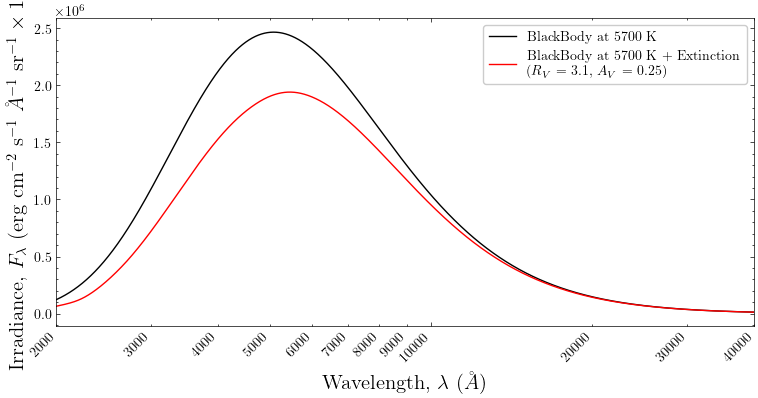

In [122]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

xlim_min, xlim_max = 2000, 40000

ax1.plot(wav, flux, c='k', label=f'BlackBody at {temp} K')
ax1.plot(wav, extinction_flux, c='r', label=f'BlackBody at {temp} K + Extinction\n($R_V$ = {Rv}, $A_V$ = {Av})')

ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$ sr$^{-1} \\times 10^7$)', fontsize=fs-3)
ax1.set_xlim(xlim_min, xlim_max)
ax1.get_xticklabels()
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(frameon=1, framealpha=1)
for label in ax1.get_xminorticklabels():
    label.set_rotation(45)
    label.set_ha('right')
plt.show()

Altogether, SED fitting may constrain the star’s **effective temperature, surface gravity, metallicity, radius, and line-of-sight extinction**.

## MCMC SED Fitting ##

First we define some helper functions. 

In [123]:
## Dict to help align model grid bands with observed bands ##

col_to_idx = {band: i for i, band in enumerate(phot_grid.columns)}
col_to_idx

{'2MASS_J': 0,
 '2MASS_H': 1,
 '2MASS_Ks': 2,
 'GALEX_NUV': 3,
 'GALEX_FUV': 4,
 'SDSS_u': 5,
 'SDSS_g': 6,
 'SDSS_r': 7,
 'SDSS_i': 8,
 'SDSS_z': 9,
 'Gaia_G': 10,
 'Gaia_BP': 11,
 'Gaia_RP': 12,
 'TYCHO_B_MvB': 13,
 'TYCHO_V_MvB': 14,
 'WISE_RSR_W1': 15,
 'WISE_RSR_W2': 16,
 'WISE_RSR_W3': 17,
 'WISE_RSR_W4': 18}

We define our prior as a combination of uniform bounds and Gaussian-like priors on the stellar parameters:

-    Metallicity ([Fe/H]) is constrained between −5 and +1, with a normal prior centered at −0.125 dex and a standard deviation of 0.234 dex.

-    Effective temperature ($T_{\mathrm{eff}}$) is restricted to lie uniformly between 4000 K and 6500 K.

-    Radius ($R$) is limited uniformly between 0.1-1.5 ($R_{\mathrm{sol}}$).

-    Surface gravity $\log (g)$ is given a truncated normal prior, centered at 4.0 with a standard deviation of 0.5 dex, truncated between 1 and 5 dex.

-   Distance ($d$) is assigned a truncated normal prior centered at the known distance to the star `dist`, with a small uncertainty of 1 pc and allowed to vary between 0 and 10,000 pc.

-    Extinction ($A_v$) is modeled with a truncated normal prior centered at 0, with a small dispersion of 0.1 mag, truncated to lie between 0 and $3\sigma$ (i.e., up to 0.3 mag).

Any parameter combination falling outside the uniform bounds is immediately assigned zero prior probability. Within the allowed regions, the likelihood is modified by the sum of the logarithms of the prior probability densities.


In [124]:
def log_truncnorm(x, mu, sigma, lower, upper):
    """
    Fast log-probability of a truncated normal distribution.
    Equivalent to truncnorm.logpdf(x, a, b, loc=mu, scale=sigma)
    """
    # Standardized bounds
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    z = (x - mu) / sigma

    # CDF terms for normalization
    cdf_a = 0.5 * (1 + erf(a / sqrt(2)))
    cdf_b = 0.5 * (1 + erf(b / sqrt(2)))
    norm = cdf_b - cdf_a

    # Return -inf outside bounds
    if x < lower or x > upper or norm <= 0:
        return -np.inf

    # Log-pdf of truncated normal
    logp = -0.5 * z**2 - log(sigma) - log(norm) - 0.5 * log(2 * pi)
    return logp

def log_norm(x, mu, sigma):
    """
    Fast log-probability of a normal distribution.
    Equivalent to norm.logpdf(x, a, b, loc=mu, scale=sigma)
    """
    # Standardized bounds
    z = (x - mu) / sigma
    # Log-pdf of truncated normal
    logp = -0.5 * z**2 - log(sigma) - 0.5 * log(2 * pi)
    return logp




######################  MCMC PRIOR  ########################

def log_prior(theta):
    met, teff, logg, rad, dist, Av  = theta
    mu_dist = dist_sunwd; sigma_dist = 1# 10*dist_mu
    mu_av = 0; sigma_av = 0.1

    if not np.all(np.isfinite(theta)):
        print("Non-finite parameter:", theta)
        return -np.inf

    if not (-5 < met < 1 and 4000 < teff < 6500 and 0.1 < rad < 1.5):
        return -np.inf
    
    # Truncated normal on distance
    logp_dist = log_truncnorm(dist,mu=mu_dist, sigma = sigma_dist, lower=0, upper=10000)
    logp_av = log_truncnorm(Av, mu = mu_av, sigma = sigma_av, 
                            lower=(0*sigma_av + mu_av), upper=(3*sigma_av + mu_av))
    logp_feh = log_norm(met, mu =-0.125, sigma=0.234)
    logp_logg = log_truncnorm(logg,mu=4, sigma = 0.5, lower=1, upper=5)

    return logp_dist + logp_av + logp_feh + logp_logg


######################  LOG LIKELIHOOD  ########################

def log_likelihood(params,wav, flux,sigma,interpolator):
    model = model_flux_emcee(params,wav, interpolator)
    
    if model is None:
        return -np.inf
    
    residuals = (flux - model)/sigma
    return -0.5 *np.sum( np.log(2 * np.pi * sigma**2) + residuals**2 )



######################  LOG POSTERIOR  ########################


def log_posterior(x,wav, flux,sigma,interpolator):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x, wav, flux,sigma,interpolator)


######################  MODEL TO FIT  ########################


def model_flux_emcee(params,wav,interpolator):
    met, teff, logg, rad, dist, Av  = params
    
    model = interpolator([met, teff, logg]) 
    
    if not np.all(np.isfinite(model)):
        return None
    
    model  = np.array([model[col_to_idx[b]] for b in bands]) # Get the SED in the correct order
    
    r = rad *u.solRad
    r = r.value
    d = dist * u.pc.to(u.solRad)
    norm = (r / d) ** 2
    ext = av_law(wav, Av, 3.1)

    return  apply(ext, model) * norm

We now invoke the sampler using `emcee`. 

```{important}
Ensure that your starting position is within the bounds of your prior, otherwise the parameter space will not be explored.
```


In [ ]:
import emcee 

nwalkers = 50
nsteps = 25000

## Define starting position for sampler ##
init_vals = {
    "met": 0,
    "teff": 5000,
    "logg": 2.5,
    "rad": 1,
    "dist": dist,
    'Av': 0.1
}

param_order = ["met", "teff",  "logg", "rad", "dist", "Av"]
theta_init = np.array([init_vals[param] for param in param_order])

p0 = theta_init + 1e-2 * np.random.randn(nwalkers, len(param_order))  ## Starting position

logp_func = log_posterior   ## The log posterior function encapsulates the likelihood and prior
args_func = (obs_wav, obs_flux, obs_flux_err, interpolator)  ## Additional arguments other than than parameter vector


sampler = emcee.EnsembleSampler(nwalkers, len(param_order),
                                logp_func,
                                args=args_func)
print("Running MCMC...")
sampler.run_mcmc(p0, nsteps, progress=True)
print("Sampling complete.")


Running MCMC...


 38%|████████████████████████████████████████▊                                                                  | 9532/25000 [00:58<01:31, 168.91it/s]